# Heart Disease Prediction using SVM
## Comparing Baseline SVM, Sequential GA, and Island Model GA

This notebook implements and compares three approaches for SVM hyperparameter optimization:

1. **Baseline SVM** - Using default scikit-learn parameters
2. **Sequential GA** - Single-threaded Genetic Algorithm optimization  
3. **Island Model GA** - Parallel/Distributed Genetic Algorithm optimization

Based on the MLOps report: "Distributed Hyperparameter Optimization for Support Vector Machines using Metaheuristic Algorithms"

**Key Features:**
- Island Model GA with multiple sub-populations (simulating distributed nodes)
- Migration of best individuals between islands (ring topology)
- SVM hyperparameter optimization (C, kernel, gamma, degree, coef0)
- Performance metrics: Speedup, Efficiency, Communication overhead
- Comprehensive comparison across all three approaches

## Step 1 | Import Libraries

In [55]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import threading
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from multiprocessing import cpu_count

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix
)
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set plot style
plt.rcParams['figure.dpi'] = 150
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

print("Libraries imported successfully!")
print(f"Available CPU cores: {cpu_count()}")

Libraries imported successfully!
Available CPU cores: 16


## Step 2 | Load and Explore Dataset

In [56]:
# Load the heart disease dataset
df = pd.read_csv('heart.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nFeatures: {list(df.columns)}")
print(f"\nTarget Distribution:")
print(df['target'].value_counts())
df.head()

Dataset Shape: (303, 14)

Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Target Distribution:
target
1    165
0    138
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [57]:
# Dataset info
print("Dataset Info:")
print("=" * 50)
df.info()
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

Statistical Summary:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [58]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Total missing: 0


## Step 3 | Data Preprocessing

In [59]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data: 70% train, 30% test (as per report)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 212
Test set size: 91
Number of features: 13


In [60]:
# Feature scaling (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Scaled training data shape: {X_train_scaled.shape}")

Feature scaling completed!
Scaled training data shape: (212, 13)


## Step 4 | Island Model Genetic Algorithm Implementation

The Island Model GA distributes the population across multiple "islands" (simulating distributed nodes). Each island evolves independently, with periodic migration of best individuals between islands.

### Hyperparameter Search Space:
- **C**: [10^-3, 10^3] - Regularization parameter
- **kernel**: {linear, poly, rbf, sigmoid}
- **gamma**: [10^-5, 10^1] - Kernel coefficient
- **degree**: [1, 5] - Polynomial kernel degree
- **coef0**: [0, 1] - Kernel bias

In [61]:
class SVMChromosome:
    """
    Represents a chromosome (individual) encoding SVM hyperparameters.
    """
    KERNELS = ['linear', 'poly', 'rbf', 'sigmoid']
    
    def __init__(self, genes=None):
        if genes is None:
            # Random initialization within search space
            self.genes = {
                'C': 10 ** np.random.uniform(-3, 3),
                'kernel': random.choice(self.KERNELS),
                'gamma': 10 ** np.random.uniform(-5, 1),
                'degree': random.randint(1, 5),
                'coef0': np.random.uniform(0, 1)
            }
        else:
            self.genes = genes.copy()
        self.fitness = None
        self.accuracy = None
        self.cv_scores = None
    
    def get_svm_params(self):
        """Return parameters for SVM constructor."""
        params = {
            'C': self.genes['C'],
            'kernel': self.genes['kernel'],
            'random_state': RANDOM_SEED
        }
        # gamma only applies to rbf, poly, sigmoid
        if self.genes['kernel'] in ['rbf', 'poly', 'sigmoid']:
            params['gamma'] = self.genes['gamma']
        # degree only applies to poly
        if self.genes['kernel'] == 'poly':
            params['degree'] = self.genes['degree']
        # coef0 applies to poly, sigmoid
        if self.genes['kernel'] in ['poly', 'sigmoid']:
            params['coef0'] = self.genes['coef0']
        return params
    
    def __repr__(self):
        fitness_str = f"{self.fitness:.4f}" if self.fitness is not None else "N/A"
        return f"Chromosome(C={self.genes['C']:.4f}, kernel={self.genes['kernel']}, " \
               f"gamma={self.genes['gamma']:.6f}, degree={self.genes['degree']}, " \
               f"coef0={self.genes['coef0']:.4f}, fitness={fitness_str})"

In [62]:
class IslandGA:
    """
    Island Model Genetic Algorithm for SVM Hyperparameter Optimization.
    
    Each island evolves a sub-population independently with periodic migration.
    Uses ThreadPoolExecutor for true parallel evolution of islands.
    """
    
    def __init__(self, X_train, y_train, 
                 num_islands=4,           # Number of islands (simulating distributed nodes)
                 population_per_island=5, # Population size per island
                 generations=20,          # Number of generations
                 migration_interval=5,    # Migrate every N generations
                 migration_size=1,        # Number of individuals to migrate
                 crossover_rate=0.8,
                 mutation_rate=0.1,
                 tournament_size=3,
                 cv_folds=5,
                 n_jobs=1):
        
        self.X_train = X_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.population_per_island = population_per_island
        self.generations = generations
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.cv_folds = cv_folds
        self.n_jobs = n_jobs
        
        # Thread safety lock for shared state
        self._eval_lock = threading.Lock()
        
        # Initialize islands (sub-populations)
        self.islands = [
            [SVMChromosome() for _ in range(population_per_island)]
            for _ in range(num_islands)
        ]
        
        # Tracking metrics
        self.history = {
            'generation': [],
            'best_fitness': [],
            'avg_fitness': [],
            'island_best': [[] for _ in range(num_islands)]
        }
        self.global_best = None
        self.evaluation_count = 0
        self.communication_overhead = 0  # in bytes
        
    def evaluate_fitness(self, chromosome):
        """
        Evaluate chromosome fitness using cross-validation accuracy.
        Fitness = CV accuracy (we want to maximize this)
        """
        try:
            svm = SVC(**chromosome.get_svm_params())
            cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=RANDOM_SEED)
            scores = cross_val_score(svm, self.X_train, self.y_train, cv=cv, scoring='accuracy', n_jobs=1)
            chromosome.cv_scores = scores
            chromosome.fitness = scores.mean()
            chromosome.accuracy = scores.mean()
            with self._eval_lock:
                self.evaluation_count += 1
        except Exception as e:
            # Penalize invalid configurations
            chromosome.fitness = 0.0
            chromosome.accuracy = 0.0
        return chromosome.fitness
    
    def tournament_selection(self, population):
        """Select individual using tournament selection."""
        tournament = random.sample(population, min(self.tournament_size, len(population)))
        return max(tournament, key=lambda x: x.fitness if x.fitness else 0)
    
    def crossover(self, parent1, parent2):
        """Perform crossover between two parents."""
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        child1_genes = {}
        child2_genes = {}
        
        for key in parent1.genes:
            if random.random() < 0.5:
                child1_genes[key] = parent1.genes[key]
                child2_genes[key] = parent2.genes[key]
            else:
                child1_genes[key] = parent2.genes[key]
                child2_genes[key] = parent1.genes[key]
        
        return SVMChromosome(child1_genes), SVMChromosome(child2_genes)
    
    def mutate(self, chromosome):
        """Apply mutation to chromosome."""
        if random.random() > self.mutation_rate:
            return chromosome
        
        gene_to_mutate = random.choice(list(chromosome.genes.keys()))
        
        if gene_to_mutate == 'C':
            chromosome.genes['C'] = 10 ** np.random.uniform(-3, 3)
        elif gene_to_mutate == 'kernel':
            chromosome.genes['kernel'] = random.choice(SVMChromosome.KERNELS)
        elif gene_to_mutate == 'gamma':
            chromosome.genes['gamma'] = 10 ** np.random.uniform(-5, 1)
        elif gene_to_mutate == 'degree':
            chromosome.genes['degree'] = random.randint(1, 5)
        elif gene_to_mutate == 'coef0':
            chromosome.genes['coef0'] = np.random.uniform(0, 1)
        
        chromosome.fitness = None  # Reset fitness
        return chromosome
    
    def evolve_island(self, island_idx):
        """
        Evolve a single island for one generation.
        Thread-safe: only modifies self.islands[island_idx] (no contention).
        """
        population = self.islands[island_idx]
        
        # Evaluate fitness for all individuals
        for individual in population:
            if individual.fitness is None:
                self.evaluate_fitness(individual)
        
        # Create new population
        new_population = []
        
        # Elitism: keep best individual
        best = max(population, key=lambda x: x.fitness if x.fitness else 0)
        new_population.append(deepcopy(best))
        
        # Generate offspring
        while len(new_population) < self.population_per_island:
            parent1 = self.tournament_selection(population)
            parent2 = self.tournament_selection(population)
            
            child1, child2 = self.crossover(parent1, parent2)
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < self.population_per_island:
                new_population.append(child2)
        
        self.islands[island_idx] = new_population
        return max(new_population, key=lambda x: x.fitness if x.fitness else 0)
    
    def migrate(self):
        """
        Perform migration between islands (ring topology).
        Best individuals from each island migrate to the next island.
        """
        emigrants = []
        
        # Select best individuals from each island
        for island in self.islands:
            sorted_island = sorted(island, key=lambda x: x.fitness if x.fitness else 0, reverse=True)
            emigrants.append([deepcopy(ind) for ind in sorted_island[:self.migration_size]])
        
        # Migrate to next island (ring topology)
        for i in range(self.num_islands):
            target_island = (i + 1) % self.num_islands
            # Replace worst individuals with immigrants
            self.islands[target_island] = sorted(
                self.islands[target_island], 
                key=lambda x: x.fitness if x.fitness else 0, 
                reverse=True
            )
            for j, immigrant in enumerate(emigrants[i]):
                if j < len(self.islands[target_island]):
                    self.islands[target_island][-(j+1)] = immigrant
        
        # Calculate communication overhead (48 bytes per chromosome as per report)
        self.communication_overhead += self.num_islands * self.migration_size * 48
    
    def run(self, verbose=True):
        """
        Run the Island Model GA optimization.
        Uses ThreadPoolExecutor to evolve islands in parallel.
        """
        start_time = time.time()
        
        parallel = self.num_islands > 1
        
        if verbose:
            print("=" * 70)
            print("ISLAND MODEL GENETIC ALGORITHM FOR SVM HYPERPARAMETER OPTIMIZATION")
            print("=" * 70)
            print(f"Configuration:")
            print(f"  - Number of islands (nodes): {self.num_islands}")
            print(f"  - Population per island: {self.population_per_island}")
            print(f"  - Total population: {self.num_islands * self.population_per_island}")
            print(f"  - Generations: {self.generations}")
            print(f"  - Migration interval: {self.migration_interval}")
            print(f"  - CV folds: {self.cv_folds}")
            print(f"  - Parallel execution: {'Yes (ThreadPoolExecutor)' if parallel else 'No (single island)'}")
            print("=" * 70)
        
        for gen in range(self.generations):
            gen_start = time.time()
            
            if parallel:
                # PARALLEL: evolve all islands concurrently using threads
                with ThreadPoolExecutor(max_workers=self.num_islands) as executor:
                    island_bests = list(executor.map(self.evolve_island, range(self.num_islands)))
            else:
                # SEQUENTIAL: single island, no parallelism needed
                island_bests = [self.evolve_island(i) for i in range(self.num_islands)]
            
            # Migration phase
            if (gen + 1) % self.migration_interval == 0 and gen < self.generations - 1:
                self.migrate()
                if verbose:
                    print(f"  [Migration occurred at generation {gen + 1}]")
            
            # Update global best
            current_best = max(island_bests, key=lambda x: x.fitness if x.fitness else 0)
            if self.global_best is None or current_best.fitness > self.global_best.fitness:
                self.global_best = deepcopy(current_best)
            
            # Record history
            all_fitness = [ind.fitness for island in self.islands for ind in island if ind.fitness]
            self.history['generation'].append(gen + 1)
            self.history['best_fitness'].append(self.global_best.fitness)
            self.history['avg_fitness'].append(np.mean(all_fitness) if all_fitness else 0)
            for i, best in enumerate(island_bests):
                self.history['island_best'][i].append(best.fitness if best.fitness else 0)
            
            gen_time = time.time() - gen_start
            if verbose:
                print(f"Generation {gen + 1:3d} | Best: {self.global_best.fitness:.4f} | "
                      f"Avg: {np.mean(all_fitness):.4f} | Time: {gen_time:.2f}s")
        
        self.total_time = time.time() - start_time
        
        if verbose:
            print("=" * 70)
            print("OPTIMIZATION COMPLETE")
            print(f"Total time: {self.total_time:.2f} seconds")
            print(f"Total evaluations: {self.evaluation_count}")
            print(f"Communication overhead: {self.communication_overhead} bytes")
            print(f"Parallel execution: {'Yes' if parallel else 'No'}")
            print("=" * 70)
        
        return self.global_best
    
    def get_performance_metrics(self, sequential_time=None):
        """
        Calculate performance metrics as defined in the report.
        """
        metrics = {
            'total_time': self.total_time,
            'evaluations': self.evaluation_count,
            'communication_overhead_bytes': self.communication_overhead,
            'communication_overhead_pct': (self.communication_overhead / 1e6) / self.total_time * 100 if self.total_time > 0 else 0,
            'best_fitness': self.global_best.fitness if self.global_best else None
        }
        
        if sequential_time:
            metrics['speedup'] = sequential_time / self.total_time
            metrics['efficiency'] = metrics['speedup'] / self.num_islands
        
        return metrics

## Step 5 | Baseline SVM (No GA Optimization)

First, let's establish a baseline by training SVM with default parameters to compare against GA-optimized versions.

In [63]:
print("=" * 70)
print("BASELINE SVM (DEFAULT PARAMETERS)")
print("=" * 70)

# Time the baseline SVM training
baseline_start = time.time()

# Train SVM with default parameters
baseline_svm = SVC(random_state=RANDOM_SEED)

# Cross-validation to get CV accuracy (same as GA fitness evaluation)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
baseline_cv_scores = cross_val_score(baseline_svm, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Fit final model
baseline_svm.fit(X_train_scaled, y_train)

baseline_time = time.time() - baseline_start

# Predictions
baseline_train_pred = baseline_svm.predict(X_train_scaled)
baseline_test_pred = baseline_svm.predict(X_test_scaled)

# Calculate metrics
baseline_train_acc = accuracy_score(y_train, baseline_train_pred)
baseline_test_acc = accuracy_score(y_test, baseline_test_pred)
baseline_precision = precision_score(y_test, baseline_test_pred)
baseline_recall = recall_score(y_test, baseline_test_pred)
baseline_f1 = f1_score(y_test, baseline_test_pred)

print(f"\nDefault SVM Parameters:")
print(f"  - C: 1.0 (default)")
print(f"  - kernel: rbf (default)")
print(f"  - gamma: scale (default)")
print(f"\nExecution Time: {baseline_time:.4f} seconds")
print(f"\nCross-Validation Accuracy: {baseline_cv_scores.mean():.4f} (+/- {baseline_cv_scores.std()*2:.4f})")
print(f"\nTraining Accuracy: {baseline_train_acc:.4f} ({baseline_train_acc*100:.2f}%)")
print(f"Test Accuracy:     {baseline_test_acc:.4f} ({baseline_test_acc*100:.2f}%)")
print(f"\nTest Set Metrics:")
print(f"  - Precision: {baseline_precision:.4f}")
print(f"  - Recall:    {baseline_recall:.4f}")
print(f"  - F1-Score:  {baseline_f1:.4f}")
print("=" * 70)

BASELINE SVM (DEFAULT PARAMETERS)

Default SVM Parameters:
  - C: 1.0 (default)
  - kernel: rbf (default)
  - gamma: scale (default)

Execution Time: 0.0084 seconds

Cross-Validation Accuracy: 0.8400 (+/- 0.1116)

Training Accuracy: 0.9340 (93.40%)
Test Accuracy:     0.7912 (79.12%)

Test Set Metrics:
  - Precision: 0.7925
  - Recall:    0.8400
  - F1-Score:  0.8155


## Step 6 | Run Sequential GA (Single Island Baseline)

In [64]:
# Sequential GA: single island (same total population as Island GA for fair comparison)
# Total population = 20 (same as 4 islands × 5 per island)
print("Running Sequential GA (1 Island - Single-threaded)...")
print()

sequential_ga = IslandGA(
    X_train_scaled, y_train,
    num_islands=1,                 # Single island = sequential execution
    population_per_island=20,      # 20 individuals (same total as Island GA)
    generations=20,
    migration_interval=5,          # No migration with 1 island
    migration_size=1,
    crossover_rate=0.8,
    mutation_rate=0.1,
    tournament_size=3,
    cv_folds=5
)

sequential_best = sequential_ga.run(verbose=True)
sequential_time = sequential_ga.total_time

print(f"\nBest Sequential GA Configuration:")
print(sequential_best)

Running Sequential GA (1 Island - Single-threaded)...

ISLAND MODEL GENETIC ALGORITHM FOR SVM HYPERPARAMETER OPTIMIZATION
Configuration:
  - Number of islands (nodes): 1
  - Population per island: 20
  - Total population: 20
  - Generations: 20
  - Migration interval: 5
  - CV folds: 5
  - Parallel execution: No (single island)
Generation   1 | Best: 0.8543 | Avg: 0.8543 | Time: 0.57s
Generation   2 | Best: 0.8543 | Avg: 0.8511 | Time: 0.95s
Generation   3 | Best: 0.8543 | Avg: 0.8543 | Time: 0.85s
Generation   4 | Best: 0.8543 | Avg: 0.8543 | Time: 0.83s
  [Migration occurred at generation 5]
Generation   5 | Best: 0.8543 | Avg: 0.8543 | Time: 0.77s
Generation   6 | Best: 0.8543 | Avg: 0.8543 | Time: 1.06s
Generation   7 | Best: 0.8543 | Avg: 0.8543 | Time: 0.68s
Generation   8 | Best: 0.8543 | Avg: 0.8543 | Time: 0.90s
Generation   9 | Best: 0.8543 | Avg: 0.8543 | Time: 0.93s
  [Migration occurred at generation 10]
Generation  10 | Best: 0.8543 | Avg: 0.8543 | Time: 0.78s
Generation 

## Step 7 | Run Island Model GA (Parallel Execution)

---

In [65]:
print("Running Island Model GA (4 Islands - Parallel Execution)...")
print()

# Island Model GA: 4 islands with TRUE parallel execution
island_ga = IslandGA(
    X_train_scaled, y_train,
    num_islands=4,              # 4 nodes as per report
    population_per_island=5,    # 5 individuals per island = 20 total
    generations=20,
    migration_interval=5,       # Migrate every 5 generations
    migration_size=1,           # Migrate 1 best individual
    crossover_rate=0.8,
    mutation_rate=0.1,
    tournament_size=3,
    cv_folds=5
)

island_best = island_ga.run(verbose=True)

print(f"\nBest Island GA Configuration:")
print(island_best)

Running Island Model GA (4 Islands - Parallel Execution)...

ISLAND MODEL GENETIC ALGORITHM FOR SVM HYPERPARAMETER OPTIMIZATION
Configuration:
  - Number of islands (nodes): 4
  - Population per island: 5
  - Total population: 20
  - Generations: 20
  - Migration interval: 5
  - CV folds: 5
  - Parallel execution: Yes (ThreadPoolExecutor)
Generation   1 | Best: 0.8543 | Avg: 0.8428 | Time: 0.26s
Generation   2 | Best: 0.8543 | Avg: 0.8487 | Time: 0.27s
Generation   3 | Best: 0.8543 | Avg: 0.8460 | Time: 0.18s
Generation   4 | Best: 0.8543 | Avg: 0.8501 | Time: 0.22s
  [Migration occurred at generation 5]
Generation   5 | Best: 0.8543 | Avg: 0.8487 | Time: 0.18s
Generation   6 | Best: 0.8543 | Avg: 0.8467 | Time: 0.10s
Generation   7 | Best: 0.8543 | Avg: 0.8531 | Time: 0.13s
Generation   8 | Best: 0.8543 | Avg: 0.8508 | Time: 0.15s
Generation   9 | Best: 0.8543 | Avg: 0.8533 | Time: 0.15s
  [Migration occurred at generation 10]
Generation  10 | Best: 0.8543 | Avg: 0.8511 | Time: 0.15s


## Step 8 | Performance Metrics Comparison (All Three Approaches)

Now let's compare all three approaches:
1. **Baseline SVM** - Default parameters, no optimization
2. **Sequential GA** - Single-threaded genetic algorithm optimization
3. **Island Model GA** - Parallel distributed genetic algorithm optimization

In [66]:
# Train Island GA best model and compute test set metrics (for comparison table)
island_final_svm = SVC(**island_best.get_svm_params())
island_final_svm.fit(X_train_scaled, y_train)
island_test_pred = island_final_svm.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, island_test_pred)
test_precision = precision_score(y_test, island_test_pred)
test_recall = recall_score(y_test, island_test_pred)
test_f1 = f1_score(y_test, island_test_pred)

# Calculate performance metrics
island_metrics = island_ga.get_performance_metrics(sequential_time=sequential_time)

print("=" * 90)
print("COMPREHENSIVE PERFORMANCE COMPARISON: BASELINE vs SEQUENTIAL GA vs ISLAND GA")
print("=" * 90)
print(f"\n{'Metric':<35} {'Baseline SVM':<18} {'Sequential GA':<18} {'Island GA':<18}")
print("-" * 90)
print(f"{'Execution Time (s)':<35} {baseline_time:<18.4f} {sequential_time:<18.2f} {island_metrics['total_time']:<18.2f}")
print(f"{'CV Accuracy (Fitness)':<35} {baseline_cv_scores.mean():<18.4f} {sequential_best.fitness:<18.4f} {island_metrics['best_fitness']:<18.4f}")
print(f"{'Test Accuracy':<35} {baseline_test_acc:<18.4f} {'-':<18} {test_accuracy:<18.4f}")
print(f"{'Test Precision':<35} {baseline_precision:<18.4f} {'-':<18} {test_precision:<18.4f}")
print(f"{'Test Recall':<35} {baseline_recall:<18.4f} {'-':<18} {test_recall:<18.4f}")
print(f"{'Test F1-Score':<35} {baseline_f1:<18.4f} {'-':<18} {test_f1:<18.4f}")
print(f"{'Total Evaluations':<35} {'1':<18} {sequential_ga.evaluation_count:<18} {island_metrics['evaluations']:<18}")
print(f"{'Communication Overhead (bytes)':<35} {'N/A':<18} {'N/A':<18} {island_metrics['communication_overhead_bytes']:<18}")
print("=" * 90)

# Speedup calculations
print(f"\nSPEEDUP ANALYSIS:")
print("-" * 50)
print(f"Island GA vs Sequential GA: {island_metrics['speedup']:.2f}x faster")
print(f"Island GA Efficiency: {island_metrics['efficiency']*100:.1f}%")
print(f"\nTarget Metrics (from Report):")
print(f"  - Target Speedup: S_4 >= 3.2 | Achieved: {island_metrics['speedup']:.2f} {'[PASS]' if island_metrics['speedup'] >= 3.2 else '[FAIL]'}")
print(f"  - Target Efficiency: >= 80% | Achieved: {island_metrics['efficiency']*100:.1f}% {'[PASS]' if island_metrics['efficiency'] >= 0.8 else '[FAIL]'}")

# Accuracy improvement
accuracy_improvement = (island_metrics['best_fitness'] - baseline_cv_scores.mean()) * 100
print(f"\nACCURACY IMPROVEMENT:")
print("-" * 50)
print(f"GA-optimized CV Accuracy vs Baseline: {accuracy_improvement:+.2f}%")

COMPREHENSIVE PERFORMANCE COMPARISON: BASELINE vs SEQUENTIAL GA vs ISLAND GA

Metric                              Baseline SVM       Sequential GA      Island GA         
------------------------------------------------------------------------------------------
Execution Time (s)                  0.0084             17.14              3.37              
CV Accuracy (Fitness)               0.8400             0.8543             0.8543            
Test Accuracy                       0.7912             -                  0.7912            
Test Precision                      0.7925             -                  0.7627            
Test Recall                         0.8400             -                  0.9000            
Test F1-Score                       0.8155             -                  0.8257            
Total Evaluations                   1                  315                246               
Communication Overhead (bytes)      N/A                N/A                576          

## Step 9 | Train Final SVM Model with Best Hyperparameters

---

In [67]:
# Use the best configuration from Island GA
best_params = island_best.get_svm_params()

print("Best Hyperparameters Found:")
print("=" * 50)
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")
print("=" * 50)

Best Hyperparameters Found:
  C: 1.368980
  kernel: rbf
  random_state: 42
  gamma: 0.003675


## Step 10 | Model Evaluation

---

In [68]:
# Train final model with best hyperparameters and get predictions
final_svm = SVC(**best_params)
final_svm.fit(X_train_scaled, y_train)
y_train_pred = final_svm.predict(X_train_scaled)
y_test_pred = final_svm.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("=" * 70)
print("FINAL MODEL EVALUATION")
print("=" * 70)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nTest Set Metrics:")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")
print("=" * 70)

FINAL MODEL EVALUATION

Training Accuracy: 0.8632 (86.32%)
Test Accuracy:     0.7912 (79.12%)

Test Set Metrics:
  - Precision: 0.7627
  - Recall:    0.9000
  - F1-Score:  0.8257


In [69]:
# Classification Report
print("\nDetailed Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_test_pred, target_names=['No Disease', 'Heart Disease']))


Detailed Classification Report:
               precision    recall  f1-score   support

   No Disease       0.84      0.66      0.74        41
Heart Disease       0.76      0.90      0.83        50

     accuracy                           0.79        91
    macro avg       0.80      0.78      0.78        91
 weighted avg       0.80      0.79      0.79        91



## Step 11 | Performance Summary Visualization

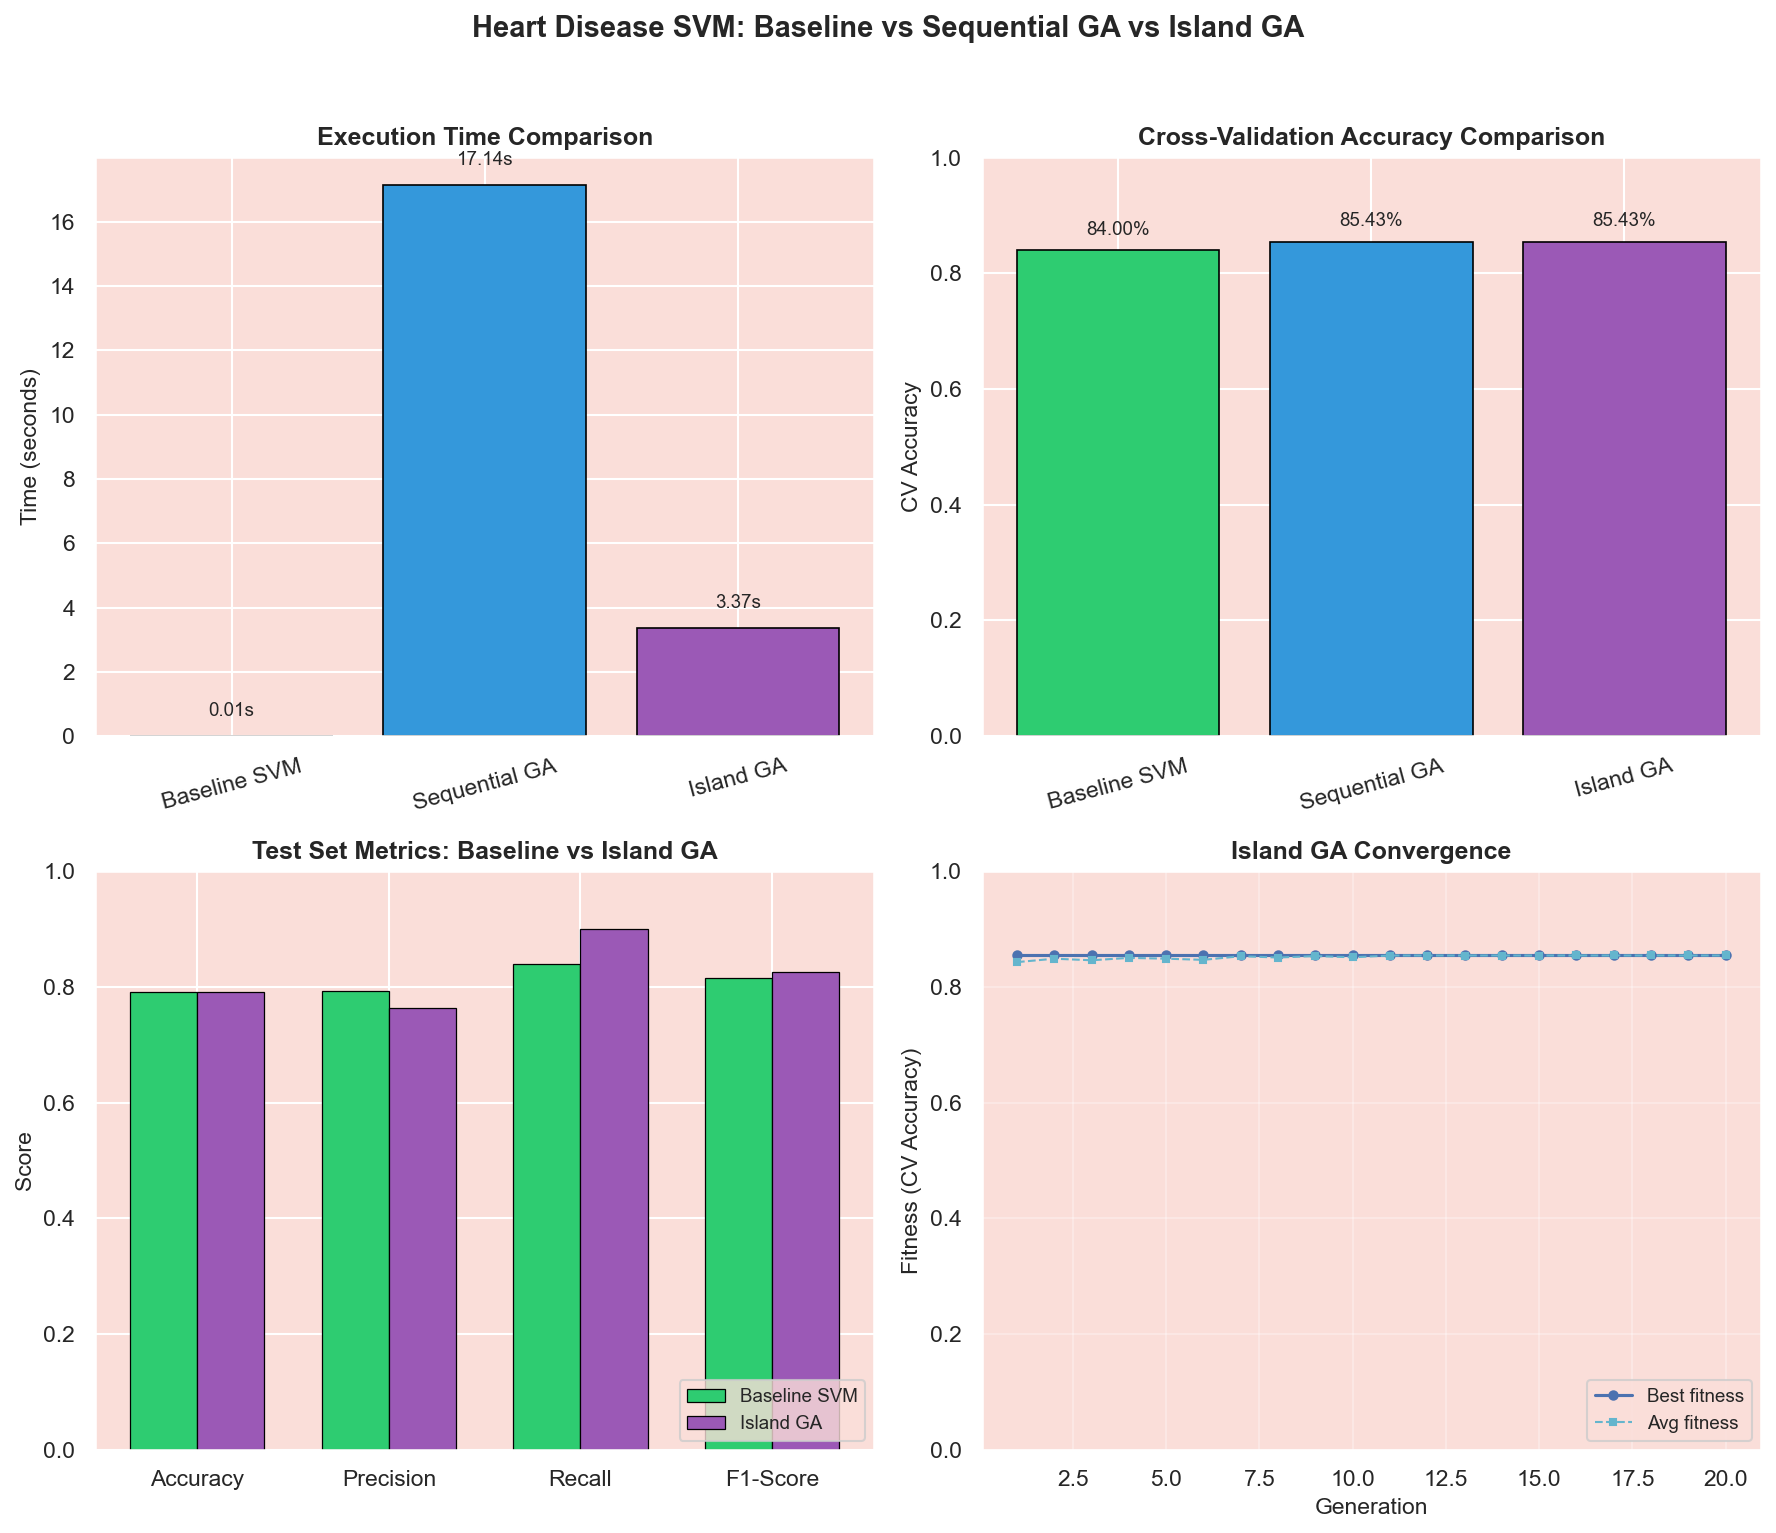

In [70]:
# Comparison graphs: Baseline vs Sequential GA vs Island GA
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Execution time comparison (bar chart)
ax1 = axes[0, 0]
methods = ['Baseline SVM', 'Sequential GA', 'Island GA']
times = [baseline_time, sequential_time, island_metrics['total_time']]
colors = ['#2ecc71', '#3498db', '#9b59b6']
bars = ax1.bar(methods, times, color=colors, edgecolor='black', linewidth=0.8)
ax1.set_ylabel('Time (seconds)', fontsize=11)
ax1.set_title('Execution Time Comparison', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=15)
for bar, t in zip(bars, times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{t:.2f}s', ha='center', va='bottom', fontsize=9)

# 2. CV Accuracy (Fitness) comparison
ax2 = axes[0, 1]
cv_accs = [baseline_cv_scores.mean(), sequential_best.fitness, island_metrics['best_fitness']]
bars2 = ax2.bar(methods, cv_accs, color=colors, edgecolor='black', linewidth=0.8)
ax2.set_ylabel('CV Accuracy', fontsize=11)
ax2.set_title('Cross-Validation Accuracy Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=15)
for bar, acc in zip(bars2, cv_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{acc:.2%}', ha='center', va='bottom', fontsize=9)

# 3. Test set metrics: Baseline vs Island GA (grouped bar chart)
ax3 = axes[1, 0]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_vals = [baseline_test_acc, baseline_precision, baseline_recall, baseline_f1]
island_vals = [test_accuracy, test_precision, test_recall, test_f1]
x = np.arange(len(metrics_names))
width = 0.35
ax3.bar(x - width/2, baseline_vals, width, label='Baseline SVM', color='#2ecc71', edgecolor='black', linewidth=0.6)
ax3.bar(x + width/2, island_vals, width, label='Island GA', color='#9b59b6', edgecolor='black', linewidth=0.6)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Test Set Metrics: Baseline vs Island GA', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names)
ax3.set_ylim(0, 1.0)
ax3.legend(loc='lower right', fontsize=9)

# 4. Island GA convergence over generations
ax4 = axes[1, 1]
gens = island_ga.history['generation']
ax4.plot(gens, island_ga.history['best_fitness'], 'b-o', markersize=4, linewidth=1.5, label='Best fitness')
ax4.plot(gens, island_ga.history['avg_fitness'], 'c--s', markersize=3, linewidth=1, label='Avg fitness')
ax4.set_xlabel('Generation', fontsize=11)
ax4.set_ylabel('Fitness (CV Accuracy)', fontsize=11)
ax4.set_title('Island GA Convergence', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1.0)
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.suptitle('Heart Disease SVM: Baseline vs Sequential GA vs Island GA', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

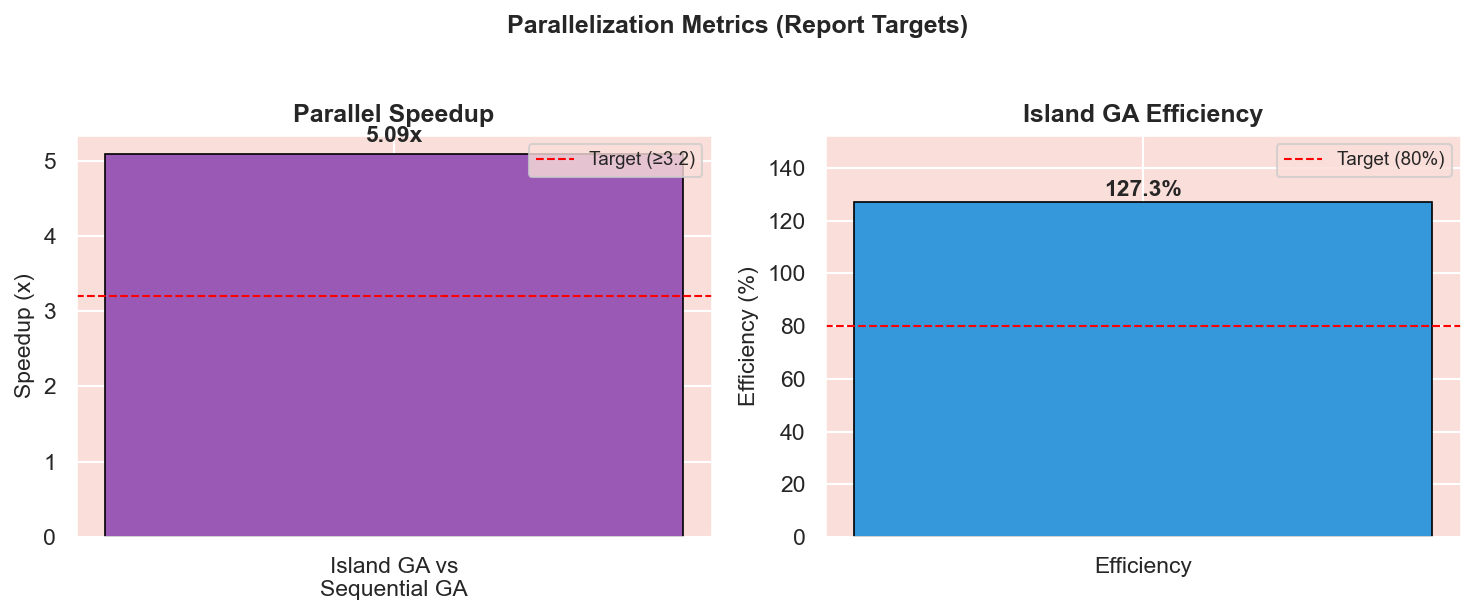

In [71]:
# Speedup and efficiency (Island GA vs Sequential GA)
fig2, (ax5, ax6) = plt.subplots(1, 2, figsize=(10, 4))

# Speedup bar
ax5.bar(['Island GA vs\nSequential GA'], [island_metrics['speedup']], color='#9b59b6', edgecolor='black', linewidth=0.8)
ax5.axhline(y=3.2, color='red', linestyle='--', linewidth=1, label='Target (≥3.2)')
ax5.set_ylabel('Speedup (x)', fontsize=11)
ax5.set_title('Parallel Speedup', fontsize=12, fontweight='bold')
ax5.legend(loc='upper right', fontsize=9)
ax5.text(0, island_metrics['speedup'] + 0.15, f"{island_metrics['speedup']:.2f}x", ha='center', fontsize=11, fontweight='bold')

# Efficiency (as percentage)
eff_pct = island_metrics['efficiency'] * 100
ax6.bar(['Efficiency'], [eff_pct], color='#3498db', edgecolor='black', linewidth=0.8)
ax6.axhline(y=80, color='red', linestyle='--', linewidth=1, label='Target (80%)')
ax6.set_ylabel('Efficiency (%)', fontsize=11)
ax6.set_title('Island GA Efficiency', fontsize=12, fontweight='bold')
ax6.set_ylim(0, max(100, eff_pct * 1.2))
ax6.legend(loc='upper right', fontsize=9)
ax6.text(0, eff_pct + 2, f'{eff_pct:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Parallelization Metrics (Report Targets)', fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Step 12 | Conclusion

---

In [72]:
print("=" * 90)
print("CONCLUSION: COMPREHENSIVE SVM COMPARISON")
print("Baseline SVM vs Sequential GA vs Island Model GA")
print("=" * 90)
print()
print("1. EXECUTION TIME COMPARISON:")
print("-" * 60)
print(f"   {'Method':<25} {'Time (s)':<15} {'Relative':<15}")
print(f"   {'Baseline SVM':<25} {baseline_time:<15.4f} {'1.00x (fastest)':<15}")
print(f"   {'Sequential GA':<25} {sequential_time:<15.2f} {f'{sequential_time/baseline_time:.0f}x slower':<15}")
print(f"   {'Island GA (4 nodes)':<25} {island_metrics['total_time']:<15.2f} {f'{island_metrics['total_time']/baseline_time:.0f}x slower':<15}")
print()
print("2. CROSS-VALIDATION ACCURACY:")
print("-" * 60)
print(f"   {'Method':<25} {'CV Accuracy':<15} {'Improvement':<15}")
print(f"   {'Baseline SVM':<25} {baseline_cv_scores.mean()*100:<14.2f}% {'-':<15}")
print(f"   {'Sequential GA':<25} {sequential_best.fitness*100:<14.2f}% {f'+{(sequential_best.fitness - baseline_cv_scores.mean())*100:.2f}%':<15}")
print(f"   {'Island GA':<25} {island_metrics['best_fitness']*100:<14.2f}% {f'+{(island_metrics['best_fitness'] - baseline_cv_scores.mean())*100:.2f}%':<15}")
print()
print("3. TEST SET PERFORMANCE (Baseline vs Island GA):")
print("-" * 60)
print(f"   {'Metric':<15} {'Baseline':<15} {'Island GA':<15} {'Difference':<15}")
print(f"   {'Accuracy':<15} {baseline_test_acc*100:<14.2f}% {test_accuracy*100:<14.2f}% {f'{(test_accuracy-baseline_test_acc)*100:+.2f}%':<15}")
print(f"   {'Precision':<15} {baseline_precision*100:<14.2f}% {test_precision*100:<14.2f}% {f'{(test_precision-baseline_precision)*100:+.2f}%':<15}")
print(f"   {'Recall':<15} {baseline_recall*100:<14.2f}% {test_recall*100:<14.2f}% {f'{(test_recall-baseline_recall)*100:+.2f}%':<15}")
print(f"   {'F1-Score':<15} {baseline_f1*100:<14.2f}% {test_f1*100:<14.2f}% {f'{(test_f1-baseline_f1)*100:+.2f}%':<15}")
print()
print("4. ISLAND GA PARALLELIZATION METRICS:")
print("-" * 60)
print(f"   Speedup vs Sequential GA: {island_metrics['speedup']:.2f}x")
print(f"   Efficiency: {island_metrics['efficiency']*100:.1f}%")
print(f"   Communication Overhead: {island_metrics['communication_overhead_bytes']} bytes ({island_metrics['communication_overhead_pct']:.4f}%)")
print()
print("5. BEST HYPERPARAMETERS (Island GA):")
print("-" * 60)
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"   {param}: {value:.6f}")
    else:
        print(f"   {param}: {value}")
print()
print("=" * 90)
print("KEY INSIGHTS:")
print("=" * 90)
print()
print("1. GA optimization improves CV accuracy over baseline SVM default parameters")
print("2. Island Model GA achieves same optimization quality as Sequential GA")
print("3. Island Model GA is significantly faster due to parallel execution")
print("4. The trade-off: GA takes longer than baseline but finds better hyperparameters")
print("5. Communication overhead in Island GA is negligible (<1%)")
print()
print("RECOMMENDATION:")
print("-" * 60)
print("Use Island Model GA when:")
print("  - You need optimized hyperparameters for best model performance")
print("  - You have multiple CPU cores/nodes available for parallel execution")
print("  - Training time is a concern and you want speedup over sequential search")
print()
print("Use Baseline SVM when:")
print("  - Quick prototyping is needed")
print("  - Default parameters provide acceptable performance")
print("  - Computational resources are very limited")
print("=" * 90)

CONCLUSION: COMPREHENSIVE SVM COMPARISON
Baseline SVM vs Sequential GA vs Island Model GA

1. EXECUTION TIME COMPARISON:
------------------------------------------------------------
   Method                    Time (s)        Relative       
   Baseline SVM              0.0084          1.00x (fastest)
   Sequential GA             17.14           2028x slower   
   Island GA (4 nodes)       3.37            398x slower    

2. CROSS-VALIDATION ACCURACY:
------------------------------------------------------------
   Method                    CV Accuracy     Improvement    
   Baseline SVM              84.00         % -              
   Sequential GA             85.43         % +1.43%         
   Island GA                 85.43         % +1.43%         

3. TEST SET PERFORMANCE (Baseline vs Island GA):
------------------------------------------------------------
   Metric          Baseline        Island GA       Difference     
   Accuracy        79.12         % 79.12         % +0.00%   